## **INSTALLING THE PACKAGES**

In [1]:
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !pip install beautifulsoup4
# !pip install lxml
# !pip install textblob
# !pip install mlxtend
# !pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

## **LOADING THE LIBRARIES**

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import preprocess_kgptalkie as ps
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

## **LOADING THE DATASET**

In [3]:
df = pd.read_csv("data/IMDB Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.shape

(50000, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## **PREPROCESSING**

In [7]:
df['word_count'] = df["review"].apply(lambda x: ps.word_count(x))
df['char_count'] = df["review"].apply(lambda x: ps.char_count(x))
df['avg_wordlegth'] = df["review"].apply(lambda x: ps.avg_word_len(x))
df['stopwords_count'] = df["review"].apply(lambda x: ps.stop_words_count(x))

df['review'] = df['review'].apply(lambda x: ps.remove_html_tags(x))
df['review'] = df['review'].str.lower()

In [8]:
df['review_without_stopwords'] = df['review'].apply(lambda x: ps.remove_stop_words(x))

In [9]:
df.head()

,review,sentiment,word_count,char_count,avg_wordlegth,stopwords_count,review_without_stopwords
0,one of the other reviewers has mentioned that ...,positive,307,1455,4.739414,147,reviewers mentioned watching 1 oz episode you'...
1,a wonderful little production. the filming tec...,positive,162,837,5.166667,75,wonderful little production. filming technique...
2,i thought this was a wonderful way to spend ti...,positive,166,761,4.584337,87,thought wonderful way spend time hot summer we...
3,basically there's a family where a little boy ...,negative,138,611,4.427536,67,basically there's family little boy (jake) thi...
4,"petter mattei's ""love in the time of money"" is...",positive,230,1088,4.730435,111,"petter mattei's ""love time money"" visually stu..."


In [12]:
df.columns

Index(['review', 'sentiment', 'word_count', 'char_count', 'avg_wordlegth',
       'stopwords_count', 'review_without_stopwords'],
      dtype='object')

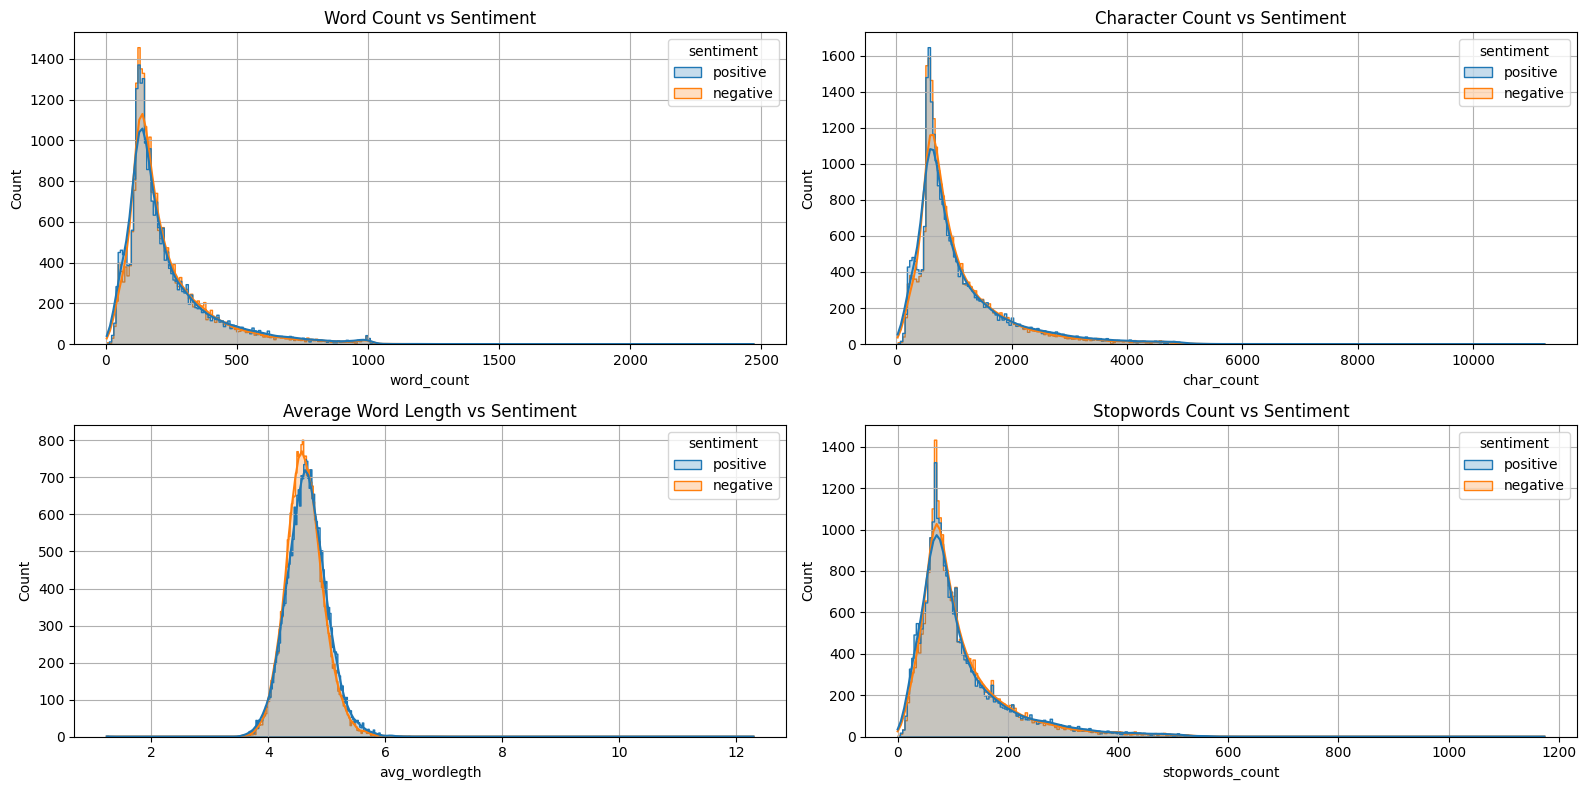

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
#sns.barplot(x='sentiment', y='word_count', data=df)
sns.histplot(data=df, x='word_count', hue='sentiment', kde=True, element="step")
plt.title('Word Count vs Sentiment')
plt.grid()

plt.subplot(2, 2, 2)
sns.histplot(data=df, x='char_count', hue='sentiment', kde=True, element="step")
plt.title('Character Count vs Sentiment')
plt.grid()

plt.subplot(2, 2, 3)
sns.histplot(data=df, x='avg_wordlegth', hue='sentiment', kde=True, element="step")
plt.title('Average Word Length vs Sentiment')
plt.grid()

plt.subplot(2, 2, 4)
sns.histplot(data=df, x='stopwords_count', hue='sentiment', kde=True, element="step")
plt.title('Stopwords Count vs Sentiment')
plt.grid()

plt.tight_layout()
plt.show()

## **FEATURE EXTRACTION AND MODEL BUILDING**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

In [22]:
X_train.shape, X_test.shape

((40000,), (10000,))

In [23]:
y_train.shape, y_test.shape

((40000,), (10000,))

**Cresting the pipeline**

In [27]:
clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

In [28]:
clf.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [30]:
y_pred = clf.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.91      0.90      0.90      5000
    positive       0.90      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



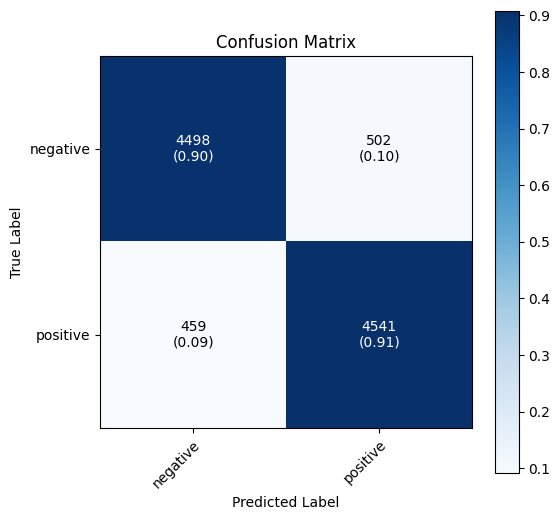

In [34]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                class_names=clf.classes_,
                                figsize=(6, 6),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [35]:
clf.predict(["This movie was fantastic! I really loved it and would watch it again."])

array(['positive'], dtype=object)

In [36]:
clf.predict(["this is a real bullshit movie. I hated it and the plot was terrible."])

array(['negative'], dtype=object)

In [38]:
pickle.dump(clf, open('imdb_sentiment_model.pkl', 'wb'))